Harsh Karia <br>
GitHub Username: harshkaria <br>
USC ID: 5860082592 <br>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.special import softmax
from scipy.spatial import distance
from sklearn.cluster import SpectralClustering

In [7]:
def getTrainTestData():
    train_positive, test_positive = train_test_split(positive_data, test_size=0.2)
    train_negative, test_negative = train_test_split(negative_data, test_size=0.2)
    train = pd.concat([train_positive, train_negative])
    test = pd.concat([test_positive, test_negative])
    train = train.sample(frac=1)
    test = test.sample(frac=1)
    return train, test

In [8]:
def plotCnfMatAUC(y_data, y_data_pred, auc_data, title):
    cnf_matrix = confusion_matrix(y_data, y_data_pred)
    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'Confusion Matrix - {title}', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_data)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [23]:
def find_spectral_roc(cluster_0, cluster_1, all_cluster, actual_data):
    actual_data = actual_data.copy()
    actual_data = actual_data.reset_index(drop=True)
    tpr_list = []
    fpr_list = []
    for major in np.linspace(0.0, 1.0, num=11):
        true_labels_0 = []
        true_labels_1 = []

        for index, row in spectral_clust_data_0.sample(n=min(30, spectral_clust_data_0.shape[0])).iterrows():
            true_labels_0.append(row["Diagnosis"])

        for index, row in spectral_clust_data_1.sample(n=min(30, spectral_clust_data_1.shape[0])).iterrows():
            true_labels_1.append(row["Diagnosis"])
            
        itemA = true_labels_0.count('M')
        itemB = true_labels_0.count('B')
        if(itemA/(itemA+itemB)>=major):
            majority_0 = 'M'
        else:
            majority_0 = 'B'
        
            
        itemA = true_labels_1.count('M')
        itemB = true_labels_1.count('B')
        if(itemA/(itemA+itemB)>=major):
            majority_1 = 'M'
        else:
            majority_1 = 'B'

        pred = []

        for index, row in all_cluster.iterrows():
            if(row["Clusters"]==0):
                pred.append(majority_0)
            else:
                pred.append(majority_1)

        tp = 0
        fp = 0
        for i in range(actual_data.shape[0]):
            if(actual_data["Diagnosis"].iloc[i]==pred[i] and pred[i]=='M'):
                tp += 1
            elif(actual_data["Diagnosis"].iloc[i]!=pred[i] and pred[i]=='M'):
                fp += 1
        tpr = tp/actual_data.loc[actual_data["Diagnosis"]=='M'].shape[0]
        fpr = fp/actual_data.loc[actual_data["Diagnosis"]=='B'].shape[0]
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    fpr_list.sort()
    tpr_list.sort()
    return fpr_list, tpr_list

In [13]:
def split_labeled_unlabeled_data(data):
    pos_data = data.loc[data["Diagnosis"]=="M"]
    neg_data = data.loc[data["Diagnosis"]=="B"]
    pos_half_data, pos_other_half_data = train_test_split(pos_data, test_size=0.5)
    neg_half_data, neg_other_half_data = train_test_split(neg_data, test_size=0.5)
    labelled_data = pd.concat([pos_half_data, neg_half_data])
    unlabelled_data = pd.concat([pos_other_half_data, neg_other_half_data])
    labelled_data = labelled_data.sample(frac=1)
    unlabelled_data = unlabelled_data.sample(frac=1)
    return labelled_data.reset_index(drop=True), unlabelled_data.reset_index(drop=True)

---
### Data

In [2]:
header_names = [f"attr_{x}" for x in range(1,31)]
header_names = ["ID", "Diagnosis"] + header_names
all_data = pd.read_csv('../data/wdbc.csv', names=header_names, index_col="ID")
all_data

,Diagnosis,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,...,attr_21,attr_22,attr_23,attr_24,attr_25,attr_26,attr_27,attr_28,attr_29,attr_30
ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [3]:
positive_data = all_data.loc[all_data["Diagnosis"]=="M"]
negative_data = all_data.loc[all_data["Diagnosis"]=="B"]

#### 1. Supervised, Semi-Supervised, and Unsupervised Learning

#### 1. b) Monte-Carlo Simulation

In [ ]:
accuracies_train = []
precisions_train = []
recalls_train = []
f1_scores_train = []
aucs_train = []

accuracies_test = []
precisions_test = []
recalls_test = []
f1_scores_test = []
aucs_test = []

for m in range(M):
    train, test = getTrainTestData()
    
    kmeans_data = train.drop(["Diagnosis"], axis=1)
    y_data = train["Diagnosis"]
    
    wcss = []
    for i in range(100):
        kmeans = KMeans(n_clusters=2, random_state = i)
        kmeans.fit(kmeans_data)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    least_index = wcss.index(min(wcss))
    kmeans = KMeans(n_clusters=2, random_state = least_index)
    kmeans.fit(kmeans_data)
    
    dist_0 = []
    dist_1 = []
    
    for index, row in kmeans_data.iterrows():
        dist_0.append(distance.euclidean(row, kmeans.cluster_centers_[0]))
        dist_1.append(distance.euclidean(row, kmeans.cluster_centers_[1]))
    
    identified_clusters = kmeans.fit_predict(kmeans_data)
    kmeans_data['Clusters'] = identified_clusters 
    kmeans_data['Distances_0'] = dist_0
    kmeans_data['Distances_1'] = dist_1
    kmeans_data['Diagnosis'] = y_data

    k_means_data_0 = kmeans_data.loc[kmeans_data['Clusters']==0]
    k_means_data_0 = k_means_data_0.sort_values(by='Distances_0', ascending=True)
    top_30_0 = k_means_data_0.head(30)
    
    k_means_data_1 = kmeans_data.loc[kmeans_data['Clusters']==1]
    k_means_data_1 = k_means_data_1.sort_values(by='Distances_1', ascending=True)
    top_30_1 = k_means_data_1.head(30)
    
    true_labels_0 = []
    true_labels_1 = []
    
    for index, row in top_30_0.iterrows():
        true_labels_0.append(row["Diagnosis"])
        
    for index, row in top_30_1.iterrows():
        true_labels_1.append(row["Diagnosis"])
    
    majority_0 = max(set(true_labels_0), key = true_labels_0.count)
    majority_1 = max(set(true_labels_1), key = true_labels_1.count)
    
    pred = []
    
    for index, row in kmeans_data.iterrows():
        if(row["Clusters"]==0):
            pred.append(majority_0)
        else:
            pred.append(majority_1)
    
    kmeans_data["Predictions"] = pred
    
    
    train_y = kmeans_data["Diagnosis"]
    train_y_pred = kmeans_data["Predictions"]
    train_y_prob = []
    
    for index, row in kmeans_data.iterrows():
        train_y_prob.append(softmax([row["Distances_0"], row["Distances_1"]]))
        if row["Clusters"]==0:
            train_y_prob[-1] = train_y_prob[-1][0]
        else:
            train_y_prob[-1] = train_y_prob[-1][1]
    
    accuracies_train.append(accuracy_score(train_y, train_y_pred))
    fpr, tpr, threshold = roc_curve(train_y, train_y_prob, pos_label="M")
    aucs_train.append(auc(fpr, tpr))
    f1_scores_train.append(f1_score(train_y, train_y_pred, pos_label="M"))
    precisions_train.append(precision_score(train_y, train_y_pred, pos_label="M"))
    recalls_train.append(recall_score(train_y, train_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(train_y, train_y_pred, aucs_train[-1], "Train")
        
        
    
    kmeans_data = test.drop(["Diagnosis"], axis=1)
    y_data = test["Diagnosis"]
    
    dist_0 = []
    dist_1 = []
    
    for index, row in kmeans_data.iterrows():
        dist_0.append(distance.euclidean(row, kmeans.cluster_centers_[0]))
        dist_1.append(distance.euclidean(row, kmeans.cluster_centers_[1]))
    
    identified_clusters = kmeans.fit_predict(kmeans_data)
    kmeans_data['Clusters'] = identified_clusters 
    kmeans_data['Distances_0'] = dist_0
    kmeans_data['Distances_1'] = dist_1
    kmeans_data['Diagnosis'] = y_data
    
    k_means_data_0 = kmeans_data.loc[kmeans_data['Clusters']==0]
    k_means_data_0 = k_means_data_0.sort_values(by='Distances_0', ascending=True)
    top_30_0 = k_means_data_0.head(30)
    
    k_means_data_1 = kmeans_data.loc[kmeans_data['Clusters']==1]
    k_means_data_1 = k_means_data_1.sort_values(by='Distances_1', ascending=True)
    top_30_1 = k_means_data_1.head(30)
    
    true_labels_0 = []
    true_labels_1 = []
    
    for index, row in top_30_0.iterrows():
        true_labels_0.append(row["Diagnosis"])
        
    for index, row in top_30_1.iterrows():
        true_labels_1.append(row["Diagnosis"])
    
    majority_0 = max(set(true_labels_0), key = true_labels_0.count)
    majority_1 = max(set(true_labels_1), key = true_labels_1.count)
    
    pred = []
    
    for index, row in kmeans_data.iterrows():
        if(row["Clusters"]==0):
            pred.append(majority_0)
        else:
            pred.append(majority_1)
    
    kmeans_data["Predictions"] = pred
    
    
    test_y = kmeans_data["Diagnosis"]
    test_y_pred = kmeans_data["Predictions"]
    test_y_prob = []
    
    for index, row in kmeans_data.iterrows():
        test_y_prob.append(softmax([row["Distances_0"], row["Distances_1"]]))
        if row["Clusters"]==0:
            test_y_prob[-1] = test_y_prob[-1][0]
        else:
            test_y_prob[-1] = test_y_prob[-1][1]
             
    accuracies_test.append(accuracy_score(test_y, test_y_pred))
    fpr, tpr, threshold = roc_curve(test_y, test_y_prob, pos_label="M")
    aucs_test.append(auc(fpr, tpr))
    f1_scores_test.append(f1_score(test_y, test_y_pred, pos_label="M"))
    precisions_test.append(precision_score(test_y, test_y_pred, pos_label="M"))
    recalls_test.append(recall_score(test_y, test_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(test_y, test_y_pred, aucs_test[-1], "Test")

In [9]:
avg_scores = {}

#### 1. b) i. Supervised Learning

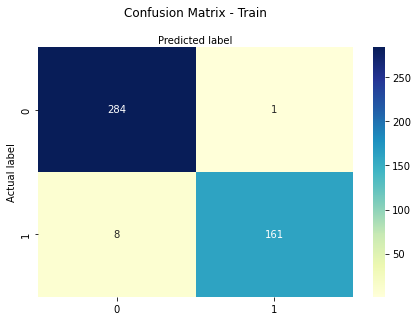

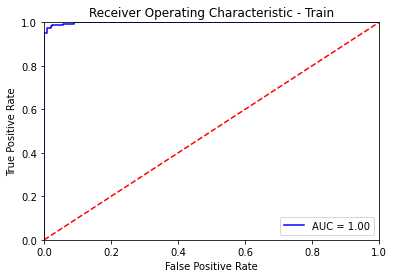

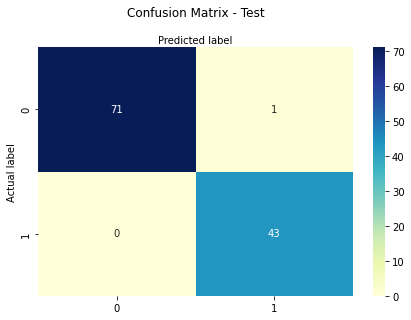

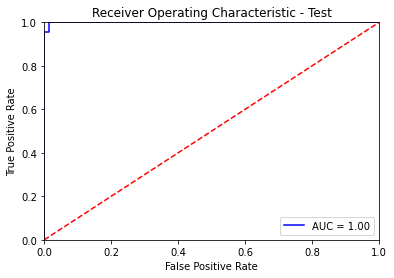

In [10]:
accuracies_train = []
precisions_train = []
recalls_train = []
f1_scores_train = []
aucs_train = []

accuracies_test = []
precisions_test = []
recalls_test = []
f1_scores_test = []
aucs_test = []

for m in range(M):
    train, test = getTrainTestData()
    train_x = train.drop(["Diagnosis"], axis=1)
    train_y = train["Diagnosis"]
    test_x = test.drop(["Diagnosis"], axis=1)
    test_y = test["Diagnosis"]

    penalties = np.linspace(10**-1, 10**9, num=20)

    best_c = 0
    best_accuracy = 0

    for c in penalties:
        cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
        model = LinearSVC(penalty='l1', C=c, dual=False)
        steps = [('scaler', Normalizer()), ('model', CalibratedClassifierCV(model))] 
        pipeline = Pipeline(steps)
        accuracy = cross_val_score(pipeline, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1).mean()
        if (accuracy>best_accuracy):
            best_accuracy = accuracy
            best_c = c

    model = LinearSVC(penalty='l1', C=best_c, dual=False)
    steps = [('scaler', Normalizer()), ('model', CalibratedClassifierCV(model) )] 
    pipeline = Pipeline(steps)
    pipeline.fit(train_x, train_y)
    train_y_pred = pipeline.predict(train_x)    
    train_y_prob = pipeline.predict_proba(train_x)
    train_y_prob = train_y_prob[:,1]
                        
    accuracies_train.append(accuracy_score(train_y, train_y_pred))
    fpr, tpr, threshold = roc_curve(train_y, train_y_prob, pos_label="M")
    aucs_train.append(auc(fpr, tpr))
    f1_scores_train.append(f1_score(train_y, train_y_pred, pos_label="M"))
    precisions_train.append(precision_score(train_y, train_y_pred, pos_label="M"))
    recalls_train.append(recall_score(train_y, train_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(train_y, train_y_pred, aucs_train[-1], "Train")
    
    test_y_pred = pipeline.predict(test_x)
    test_y_prob = pipeline.predict_proba(test_x)
    test_y_prob = test_y_prob[:,1]
             
    accuracies_test.append(accuracy_score(test_y, test_y_pred))
    fpr, tpr, threshold = roc_curve(test_y, test_y_prob, pos_label="M")
    aucs_test.append(auc(fpr, tpr))
    f1_scores_test.append(f1_score(test_y, test_y_pred, pos_label="M"))
    precisions_test.append(precision_score(test_y, test_y_pred, pos_label="M"))
    recalls_test.append(recall_score(test_y, test_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(test_y, test_y_pred, aucs_test[-1], "Test")

In [11]:
avg_scores["l1_penalized_svm"] = {
        "accuracy_test": np.mean(accuracies_test),
        "f1_score_test": np.mean(f1_scores_test),
        "precision_test": np.mean(precisions_test),
        "recall_test": np.mean(recalls_test),
        "auc_test": np.mean(aucs_test),
        "accuracy_train": np.mean(accuracies_train),
        "f1_score_train": np.mean(f1_scores_train),
        "precision_train": np.mean(precisions_train),
        "recall_train": np.mean(recalls_train),
        "auc_train": np.mean(aucs_train)
    }

In [12]:
model_scores = avg_scores['l1_penalized_svm']
summary_data = {
                'Parameters':  ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
                'Train': [model_scores['accuracy_train'], model_scores['precision_train'], model_scores['recall_train'], model_scores['f1_score_train'], model_scores['auc_train']],
                'Test': [model_scores['accuracy_test'], model_scores['precision_test'], model_scores['recall_test'], model_scores['f1_score_test'], model_scores['auc_test']]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Parameters')

,Train,Test
Parameters,,
Accuracy,0.980029,0.968116
Precision,0.998347,0.977890
Recall,0.947929,0.936434
F1 Score,0.972453,0.956064
AUC,0.999100,0.992033


#### 1. b) ii. Semi-Supervised Learning / Self-Training

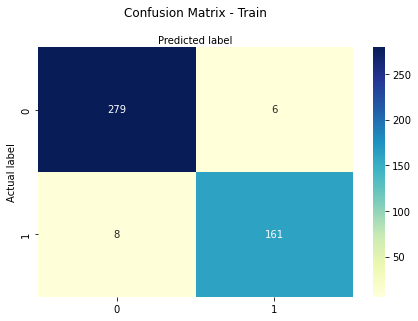

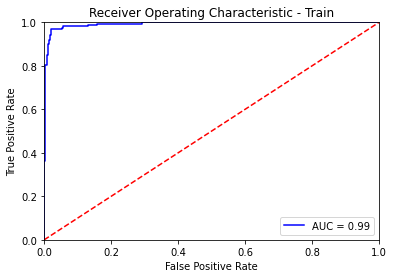

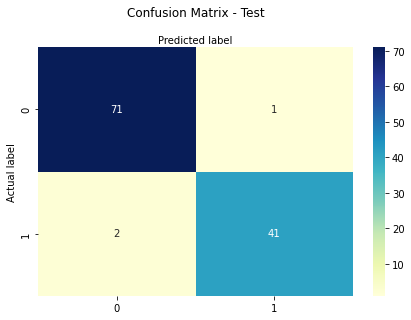

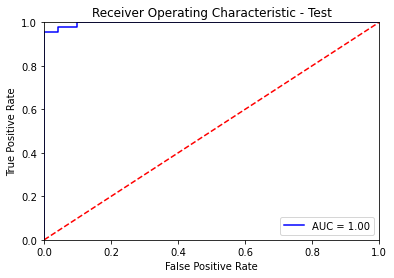

In [14]:
accuracies_train = []
precisions_train = []
recalls_train = []
f1_scores_train = []
aucs_train = []

accuracies_test = []
precisions_test = []
recalls_test = []
f1_scores_test = []
aucs_test = []

for m in range(M):
    train, test = getTrainTestData()
    train_labelled,  train_unlabelled = split_labeled_unlabeled_data(train)
    train_x_labelled = train_labelled.drop(["Diagnosis"], axis=1)
    train_y_labelled = train_labelled["Diagnosis"]
    train_y_actual_labels = train_y_labelled.copy()
    train_x_unlabelled = train_unlabelled.drop(["Diagnosis"], axis=1)
    train_y_unlabelled = train_unlabelled["Diagnosis"]
    test_x = test.drop(["Diagnosis"], axis=1)
    test_y = test["Diagnosis"]
    
    penalties = np.linspace(10**-1, 10**9, num=20)
    
    while(train_y_unlabelled.shape[0]>0):

        best_c = 0
        best_accuracy = 0

        for c in penalties:
            cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
            model = LinearSVC(penalty='l1', C=c, dual=False, num_iter=1000)
            steps = [('scaler', Normalizer()), ('model', model)] 
            pipeline = Pipeline(steps)
            accuracy = cross_val_score(pipeline, train_x_labelled, train_y_labelled, scoring='accuracy', cv=cv, n_jobs=-1).mean()
            if (accuracy>best_accuracy):
                best_accuracy = accuracy
                best_c = c

        model = LinearSVC(penalty='l1', C=best_c, dual=False)
        steps = [('scaler', Normalizer()), ('model', model )] 
        pipeline = Pipeline(steps)
        pipeline.fit(train_x_labelled, train_y_labelled)  

        y = pipeline['model'].decision_function(train_x_unlabelled)
        
        # Normalize Coefficients
        
        w_norm = np.linalg.norm(pipeline['model'].coef_)
        dist = y / w_norm
        # print(disr)

        max_dist = max(dist, key = lambda x: abs(x))

        m_d_i = np.where(dist == max_dist)

        new_x = train_x_unlabelled.iloc[m_d_i]
        
        m_d_i = m_d_i[0][0]
        
        
        new_y = pd.Series(pipeline.predict(new_x))

        train_x_labelled = pd.concat([train_x_labelled, new_x], ignore_index=True)
        train_y_labelled = pd.concat([train_y_labelled, new_y], ignore_index=True)
        
        train_y_actual_labels = pd.concat([train_y_actual_labels, pd.Series(train_y_unlabelled.iloc[new_x_index])], ignore_index=True)

        train_x_unlabelled = train_x_unlabelled.drop([new_x_index]).reset_index(drop=True)
        train_y_unlabelled = train_y_unlabelled.drop([new_x_index]).reset_index(drop=True)
    
    # Retrain
    model = LinearSVC(penalty='l1', C=best_c, dual=False)
    steps = [('scaler', Normalizer()), ('model', CalibratedClassifierCV(model) )] 
    pipeline = Pipeline(steps)
    pipeline.fit(train_x_labelled, train_y_labelled)
    train_y_pred = pipeline.predict(train_x_labelled)    
    train_y_prob = pipeline.predict_proba(train_x_labelled)
    train_y_prob = train_y_prob[:,1]
                        
    accuracies_train.append(accuracy_score(train_y_actual_labels, train_y_pred))
    fpr, tpr, threshold = roc_curve(train_y_actual_labels, train_y_prob, pos_label="M")
    aucs_train.append(auc(fpr, tpr))
    f1_scores_train.append(f1_score(train_y_actual_labels, train_y_pred, pos_label="M"))
    precisions_train.append(precision_score(train_y_actual_labels, train_y_pred, pos_label="M"))
    recalls_train.append(recall_score(train_y_actual_labels, train_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(train_y_actual_labels, train_y_pred, aucs_train[-1], "Train")
    
    
    # Test Analysis
    test_y_pred = pipeline.predict(test_x)
    test_y_prob = pipeline.predict_proba(test_x)
    test_y_prob = test_y_prob[:,1]
             
    accuracies_test.append(accuracy_score(test_y, test_y_pred))
    fpr, tpr, threshold = roc_curve(test_y, test_y_prob, pos_label="M")
    aucs_test.append(auc(fpr, tpr))
    f1_scores_test.append(f1_score(test_y, test_y_pred, pos_label="M"))
    precisions_test.append(precision_score(test_y, test_y_pred, pos_label="M"))
    recalls_test.append(recall_score(test_y, test_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(test_y, test_y_pred, aucs_test[-1], "Test")

In [15]:
avg_scores["semi_supervised_svm"] = {
        "accuracy_test": np.mean(accuracies_test),
        "f1_score_test": np.mean(f1_scores_test),
        "precision_test": np.mean(precisions_test),
        "recall_test": np.mean(recalls_test),
        "auc_test": np.mean(aucs_test),
        "accuracy_train": np.mean(accuracies_train),
        "f1_score_train": np.mean(f1_scores_train),
        "precision_train": np.mean(precisions_train),
        "recall_train": np.mean(recalls_train),
        "auc_train": np.mean(aucs_train)
    }

In [16]:
model_scores = avg_scores['semi_supervised_svm']
summary_data = {
                'Parameters':  ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
                'Train': [model_scores['accuracy_train'], model_scores['precision_train'], model_scores['recall_train'], model_scores['f1_score_train'], model_scores['auc_train']],
                'Test': [model_scores['accuracy_test'], model_scores['precision_test'], model_scores['recall_test'], model_scores['f1_score_test'], model_scores['auc_test']]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Parameters')

,Train,Test
Parameters,,
Accuracy,0.970852,0.955652
Precision,0.970138,0.960306
Recall,0.951282,0.920930
F1 Score,0.960458,0.939086
AUC,0.992934,0.988404


#### 1. b) iii. Unsupervised Learning

#### 1. b) iii. A.

We make sure that the kmeans algorithm is not trapped in a local minimum by initializing the centroids randomly every time we initialize the K Means Clusterer

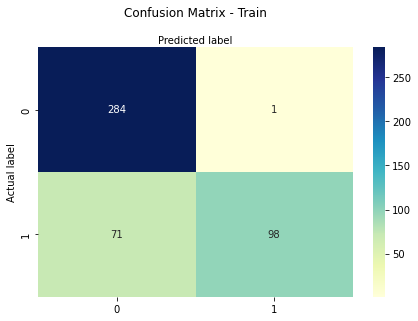

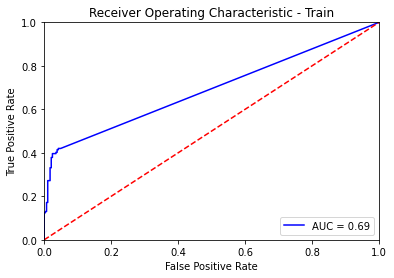

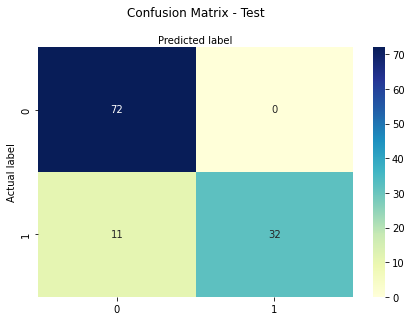

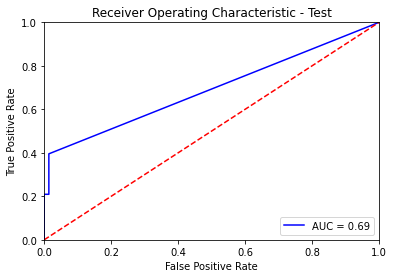

In [17]:
accuracies_train = []
precisions_train = []
recalls_train = []
f1_scores_train = []
aucs_train = []

accuracies_test = []
precisions_test = []
recalls_test = []
f1_scores_test = []
aucs_test = []

for m in range(M):
    train, test = getTrainTestData()
    
    kmeans_data = train.drop(["Diagnosis"], axis=1)
    y_data = train["Diagnosis"]
    
    wcss = []
    for i in range(100):
        kmeans = KMeans(n_clusters=2, random_state = i)
        kmeans.fit(kmeans_data)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    least_index = wcss.index(min(wcss))
    kmeans = KMeans(n_clusters=2, random_state = least_index)
    kmeans.fit(kmeans_data)
    
    dist_0 = []
    dist_1 = []
    
    for index, row in kmeans_data.iterrows():
        dist_0.append(distance.euclidean(row, kmeans.cluster_centers_[0]))
        dist_1.append(distance.euclidean(row, kmeans.cluster_centers_[1]))
    
    identified_clusters = kmeans.fit_predict(kmeans_data)
    kmeans_data['Clusters'] = identified_clusters 
    kmeans_data['Distances_0'] = dist_0
    kmeans_data['Distances_1'] = dist_1
    kmeans_data['Diagnosis'] = y_data
    
    # Cluster One
    k_means_data_0 = kmeans_data.loc[kmeans_data['Clusters']==0]
    k_means_data_0 = k_means_data_0.sort_values(by='Distances_0', ascending=True)
    top_30_0 = k_means_data_0.head(30)
    
    # Cluster Two
    k_means_data_1 = kmeans_data.loc[kmeans_data['Clusters']==1]
    k_means_data_1 = k_means_data_1.sort_values(by='Distances_1', ascending=True)
    top_30_1 = k_means_data_1.head(30)
    
    true_labels_0 = []
    true_labels_1 = []
    
    for index, row in top_30_0.iterrows():
        true_labels_0.append(row["Diagnosis"])
        
    for index, row in top_30_1.iterrows():
        true_labels_1.append(row["Diagnosis"])
    
    majority_0 = max(set(true_labels_0), key = true_labels_0.count)
    majority_1 = max(set(true_labels_1), key = true_labels_1.count)
    
    pred = []
    
    for index, row in kmeans_data.iterrows():
        if(row["Clusters"]==0):
            pred.append(majority_0)
        else:
            pred.append(majority_1)
    
    kmeans_data["Predictions"] = pred
    
    
    train_y = kmeans_data["Diagnosis"]
    train_y_pred = kmeans_data["Predictions"]
    train_y_prob = []
    
    for index, row in kmeans_data.iterrows():
        train_y_prob.append(softmax([row["Distances_0"], row["Distances_1"]]))
        if row["Clusters"]==0:
            train_y_prob[-1] = train_y_prob[-1][0]
        else:
            train_y_prob[-1] = train_y_prob[-1][1]
    
    accuracies_train.append(accuracy_score(train_y, train_y_pred))
    fpr, tpr, threshold = roc_curve(train_y, train_y_prob, pos_label="M")
    aucs_train.append(auc(fpr, tpr))
    f1_scores_train.append(f1_score(train_y, train_y_pred, pos_label="M"))
    precisions_train.append(precision_score(train_y, train_y_pred, pos_label="M"))
    recalls_train.append(recall_score(train_y, train_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(train_y, train_y_pred, aucs_train[-1], "Train")
        
        
    
    kmeans_data = test.drop(["Diagnosis"], axis=1)
    y_data = test["Diagnosis"]
    
    dist_0 = []
    dist_1 = []
    
    for index, row in kmeans_data.iterrows():
        dist_0.append(distance.euclidean(row, kmeans.cluster_centers_[0]))
        dist_1.append(distance.euclidean(row, kmeans.cluster_centers_[1]))
    
    identified_clusters = kmeans.fit_predict(kmeans_data)
    kmeans_data['Clusters'] = identified_clusters 
    kmeans_data['Distances_0'] = dist_0
    kmeans_data['Distances_1'] = dist_1
    kmeans_data['Diagnosis'] = y_data
    
    k_means_data_0 = kmeans_data.loc[kmeans_data['Clusters']==0]
    k_means_data_0 = k_means_data_0.sort_values(by='Distances_0', ascending=True)
    top_30_0 = k_means_data_0.head(30)
    
    k_means_data_1 = kmeans_data.loc[kmeans_data['Clusters']==1]
    k_means_data_1 = k_means_data_1.sort_values(by='Distances_1', ascending=True)
    top_30_1 = k_means_data_1.head(30)
    
    true_labels_0 = []
    true_labels_1 = []
    
    for index, row in top_30_0.iterrows():
        true_labels_0.append(row["Diagnosis"])
        
    for index, row in top_30_1.iterrows():
        true_labels_1.append(row["Diagnosis"])
    
    majority_0 = max(set(true_labels_0), key = true_labels_0.count)
    majority_1 = max(set(true_labels_1), key = true_labels_1.count)
    
    pred = []
    
    for index, row in kmeans_data.iterrows():
        if(row["Clusters"]==0):
            pred.append(majority_0)
        else:
            pred.append(majority_1)
    
    kmeans_data["Predictions"] = pred
    
    
    test_y = kmeans_data["Diagnosis"]
    test_y_pred = kmeans_data["Predictions"]
    test_y_prob = []
    
    for index, row in kmeans_data.iterrows():
        test_y_prob.append(softmax([row["Distances_0"], row["Distances_1"]]))
        if row["Clusters"]==0:
            test_y_prob[-1] = test_y_prob[-1][0]
        else:
            test_y_prob[-1] = test_y_prob[-1][1]
             
    accuracies_test.append(accuracy_score(test_y, test_y_pred))
    fpr, tpr, threshold = roc_curve(test_y, test_y_prob, pos_label="M")
    aucs_test.append(auc(fpr, tpr))
    f1_scores_test.append(f1_score(test_y, test_y_pred, pos_label="M"))
    precisions_test.append(precision_score(test_y, test_y_pred, pos_label="M"))
    recalls_test.append(recall_score(test_y, test_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(test_y, test_y_pred, aucs_test[-1], "Test")

In [18]:
avg_scores["unsupervised"] = {
        "accuracy_test": np.mean(accuracies_test),
        "f1_score_test": np.mean(f1_scores_test),
        "precision_test": np.mean(precisions_test),
        "recall_test": np.mean(recalls_test),
        "auc_test": np.mean(aucs_test),
        "accuracy_train": np.mean(accuracies_train),
        "f1_score_train": np.mean(f1_scores_train),
        "precision_train": np.mean(precisions_train),
        "recall_train": np.mean(recalls_train),
        "auc_train": np.mean(aucs_train)
    }

In [19]:
model_scores = avg_scores['unsupervised']
summary_data = {
                'Parameters':  ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
                'Train': [model_scores['accuracy_train'], model_scores['precision_train'], model_scores['recall_train'], model_scores['f1_score_train'], model_scores['auc_train']],
                'Test': [model_scores['accuracy_test'], model_scores['precision_test'], model_scores['recall_test'], model_scores['f1_score_test'], model_scores['auc_test']]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Parameters')

,Train,Test
Parameters,,
Accuracy,0.849706,0.787536
Precision,0.990899,0.912888
Recall,0.601775,0.657364
F1 Score,0.748395,0.719773
AUC,0.690505,0.657865


#### 1. b) iv. Spectral Clustering

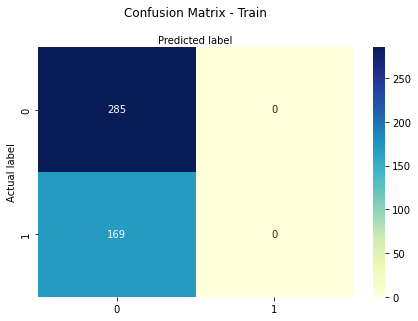

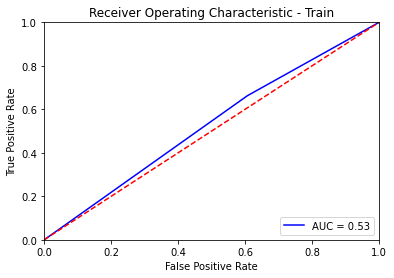

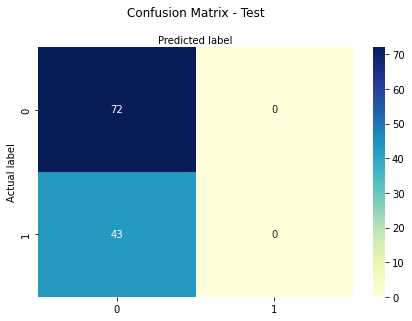

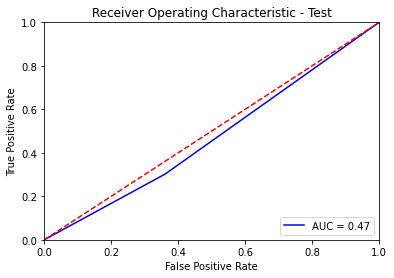

In [24]:
accuracies_train = []
precisions_train = []
recalls_train = []
f1_scores_train = []
aucs_train = []

accuracies_test = []
precisions_test = []
recalls_test = []
f1_scores_test = []
aucs_test = []

for m in range(M):
    train, test = getTrainTestData()
    
    spectral_clust_data = train.drop(["Diagnosis"], axis=1)
    y_data = train["Diagnosis"]
    
    gamma = 1
    counter = 0
    labels_0 = 0
    labels_1 = 0
    
    spectral_clust = None
    
    identified_clusters = [0 for x in range(spectral_clust_data.shape[0])]
    
    while((train.loc[train['Diagnosis']=='M'].shape[0]!=labels_0 or train.loc[train['Diagnosis']=='B'].shape[0]!=labels_1) and (train.loc[train['Diagnosis']=='B'].shape[0]!=labels_0 or train.loc[train['Diagnosis']=='M'].shape[0]!=labels_1)):
        gamma = 10*counter
        spectral_clust = SpectralClustering(n_clusters=2, gamma = gamma, affinity='rbf', n_jobs=-1)
        spectral_clust.fit(spectral_clust_data)
        identified_clusters = spectral_clust.fit_predict(spectral_clust_data)
        unique, counts = np.unique(identified_clusters, return_counts=True)
        temp = dict(zip(unique, counts))
        try:
            labels_0 = temp[0]
        except:
            labels_0 = 0
        try:
            labels_1 = temp[1]
        except:
            labels_1 = 0
        counter += 1

    spectral_clust_data['Clusters'] = identified_clusters 
    spectral_clust_data['Diagnosis'] = y_data

    spectral_clust_data_0 = spectral_clust_data.loc[spectral_clust_data['Clusters']==0]
    
    spectral_clust_data_1 = spectral_clust_data.loc[spectral_clust_data['Clusters']==1]
    
    true_labels_0 = []
    true_labels_1 = []
    
    for index, row in spectral_clust_data_0.sample(n=min(30, spectral_clust_data_0.shape[0])).iterrows():
        true_labels_0.append(row["Diagnosis"])
        
    for index, row in spectral_clust_data_1.sample(n=min(30, spectral_clust_data_1.shape[0])).iterrows():
        true_labels_1.append(row["Diagnosis"])
    
    majority_0 = max(set(true_labels_0), key = true_labels_0.count)
    majority_1 = max(set(true_labels_1), key = true_labels_1.count)
    
    pred = []
    
    for index, row in spectral_clust_data.iterrows():
        if(row["Clusters"]==0):
            pred.append(majority_0)
        else:
            pred.append(majority_1)
    
    spectral_clust_data["Predictions"] = pred
    
    
    train_y = spectral_clust_data["Diagnosis"]
    train_y_pred = spectral_clust_data["Predictions"]
    
    accuracies_train.append(accuracy_score(train_y, train_y_pred))
    fpr, tpr = getSpectralROC(spectral_clust_data_0, spectral_clust_data_1, spectral_clust_data, train)
    aucs_train.append(auc(fpr, tpr))
    f1_scores_train.append(f1_score(train_y, train_y_pred, pos_label="M"))
    precisions_train.append(precision_score(train_y, train_y_pred, pos_label="M"))
    recalls_train.append(recall_score(train_y, train_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(train_y, train_y_pred, aucs_train[-1], "Train")
        
        
    
    spectral_clust_data = test.drop(["Diagnosis"], axis=1)
    y_data = test["Diagnosis"]
    
    
    identified_clusters = spectral_clust.fit_predict(spectral_clust_data)
    spectral_clust_data['Clusters'] = identified_clusters 
    spectral_clust_data['Diagnosis'] = y_data
    
    spectral_clust_data_0 = spectral_clust_data.loc[spectral_clust_data['Clusters']==0]
    
    spectral_clust_data_1 = spectral_clust_data.loc[spectral_clust_data['Clusters']==1]
    
    true_labels_0 = []
    true_labels_1 = []
    
    for index, row in spectral_clust_data_0.sample(n=min(30, spectral_clust_data_0.shape[0])).iterrows():
        true_labels_0.append(row["Diagnosis"])
        
    for index, row in spectral_clust_data_1.sample(n=min(30, spectral_clust_data_1.shape[0])).iterrows():
        true_labels_1.append(row["Diagnosis"])
    
    majority_0 = max(set(true_labels_0), key = true_labels_0.count)
    majority_1 = max(set(true_labels_1), key = true_labels_1.count)
    
    pred = []
    
    for index, row in spectral_clust_data.iterrows():
        if(row["Clusters"]==0):
            pred.append(majority_0)
        else:
            pred.append(majority_1)
    
    spectral_clust_data["Predictions"] = pred
    
    
    test_y = spectral_clust_data["Diagnosis"]
    test_y_pred = spectral_clust_data["Predictions"]
             
    accuracies_test.append(accuracy_score(test_y, test_y_pred))
    fpr, tpr = getSpectralROC(spectral_clust_data_0, spectral_clust_data_1, spectral_clust_data, test)
    aucs_test.append(auc(fpr, tpr))
    f1_scores_test.append(f1_score(test_y, test_y_pred, pos_label="M"))
    precisions_test.append(precision_score(test_y, test_y_pred, pos_label="M"))
    recalls_test.append(recall_score(test_y, test_y_pred, pos_label="M"))
    
    if(m==0):
        plotCnfMatAUC(test_y, test_y_pred, aucs_test[-1], "Test")

In [25]:
avg_scores["spectral"] = {
        "accuracy_test": np.mean(accuracies_test),
        "f1_score_test": np.mean(f1_scores_test),
        "precision_test": np.mean(precisions_test),
        "recall_test": np.mean(recalls_test),
        "auc_test": np.mean(aucs_test),
        "accuracy_train": np.mean(accuracies_train),
        "f1_score_train": np.mean(f1_scores_train),
        "precision_train": np.mean(precisions_train),
        "recall_train": np.mean(recalls_train),
        "auc_train": np.mean(aucs_train)
    }

In [26]:
model_scores = avg_scores['spectral']
summary_data = {
                'Parameters':  ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
                'Train': [model_scores['accuracy_train'], model_scores['precision_train'], model_scores['recall_train'], model_scores['f1_score_train'], model_scores['auc_train']],
                'Test': [model_scores['accuracy_test'], model_scores['precision_test'], model_scores['recall_test'], model_scores['f1_score_test'], model_scores['auc_test']]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Parameters')

,Train,Test
Parameters,,
Accuracy,0.607122,0.610435
Precision,0.063930,0.102774
Recall,0.089941,0.133333
F1 Score,0.073613,0.113885
AUC,0.505071,0.536300


#### 1. b) v. Comparisons

In [27]:
summary_data = {
                'Models':  ['Supervised Train', 'Supervised Test', 'Semi-Supervised Train', 'Semi-Supervised Test', 'Unsupervised Train', 'Unsupervised Test', 'Spectral Clustering Train', 'Spectral Clustering Test'],
                'Accuracy': [avg_scores['l1_penalized_svm']['accuracy_train'], avg_scores['l1_penalized_svm']['accuracy_test'], avg_scores['semi_supervised_svm']['accuracy_train'], avg_scores['semi_supervised_svm']['accuracy_test'], avg_scores['unsupervised']['accuracy_train'], avg_scores['unsupervised']['accuracy_test'], avg_scores['spectral']['accuracy_train'], avg_scores['spectral']['accuracy_test']],
                'Precision': [avg_scores['l1_penalized_svm']['precision_train'], avg_scores['l1_penalized_svm']['precision_test'], avg_scores['semi_supervised_svm']['precision_train'], avg_scores['semi_supervised_svm']['precision_test'], avg_scores['unsupervised']['precision_train'], avg_scores['unsupervised']['precision_test'], avg_scores['spectral']['precision_train'], avg_scores['spectral']['precision_test']],
                'Recall': [avg_scores['l1_penalized_svm']['recall_train'], avg_scores['l1_penalized_svm']['recall_test'], avg_scores['semi_supervised_svm']['recall_train'], avg_scores['semi_supervised_svm']['recall_test'], avg_scores['unsupervised']['recall_train'], avg_scores['unsupervised']['recall_test'], avg_scores['spectral']['recall_train'], avg_scores['spectral']['recall_test']],
                'F1 Score': [avg_scores['l1_penalized_svm']['f1_score_train'], avg_scores['l1_penalized_svm']['f1_score_test'], avg_scores['semi_supervised_svm']['f1_score_train'], avg_scores['semi_supervised_svm']['f1_score_test'], avg_scores['unsupervised']['f1_score_train'], avg_scores['unsupervised']['f1_score_test'], avg_scores['spectral']['f1_score_train'], avg_scores['spectral']['f1_score_test']],
                'AUC': [avg_scores['l1_penalized_svm']['auc_train'], avg_scores['l1_penalized_svm']['auc_test'], avg_scores['semi_supervised_svm']['auc_train'], avg_scores['semi_supervised_svm']['auc_test'], avg_scores['unsupervised']['auc_train'], avg_scores['unsupervised']['auc_test'], avg_scores['spectral']['auc_train'], avg_scores['spectral']['auc_test']]
               }

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Models')

,Accuracy,Precision,Recall,F1 Score,AUC
Models,,,,,
Supervised Train,0.980029,0.998347,0.947929,0.972453,0.999100
Supervised Test,0.968116,0.977890,0.936434,0.956064,0.992033
Semi-Supervised Train,0.970852,0.970138,0.951282,0.960458,0.992934
Semi-Supervised Test,0.955652,0.960306,0.920930,0.939086,0.988404
Unsupervised Train,0.849706,0.990899,0.601775,0.748395,0.690505
Unsupervised Test,0.787536,0.912888,0.657364,0.719773,0.657865
Spectral Clustering Train,0.607122,0.063930,0.089941,0.073613,0.505071
Spectral Clustering Test,0.610435,0.102774,0.133333,0.113885,0.536300


In [ ]:
# Would unsupervised tradeoff be acceptable in prod? It would improve over time....

## Banknote Data
## 2. Active Learning Using Support Vector Machines

In [28]:
all_data = pd.read_csv('../data/data_banknote_authentication.csv', header=None)
all_data

,0,1,2,3,4
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [29]:
train_data, test_data = train_test_split(all_data, test_size=472)

#### 2. b)

In [32]:
M = 50
scores = {}

#### 2. b) i. Passive Learner

In [33]:
scores["passive"] = {}

for m in range(M):
    
    passive_test_errors = []

    current_train = train_data.copy()
    current_test = test_data.copy()
    
    penalties = np.linspace(10**-1, 10**9, num=20)
    
    current_pool, current_train = train_test_split(current_train, train_size=10)
    
    current_pool = current_pool.reset_index(drop=True)
    current_train = current_train.reset_index(drop=True)
    
    while(current_train is not None and current_train.shape[0]>=0):
    
        best_c = 0.1
        best_accuracy = 0

        for c in penalties:
            cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
            model = LinearSVC(penalty='l1', C=c, dual=False)
            steps = [('scaler', Normalizer()), ('model', model)] 
            pipeline = Pipeline(steps)
            accuracy = cross_val_score(pipeline, current_pool.drop([4], axis=1), current_pool[4], scoring='accuracy', cv=cv, n_jobs=-1).mean()
            if (accuracy>best_accuracy):
                best_accuracy = accuracy
                best_c = c

        model = LinearSVC(penalty='l1', C=best_c, dual=False)
        steps = [('scaler', Normalizer()), ('model', model )] 
        pipeline = Pipeline(steps)
        pipeline.fit(current_pool.drop([4], axis=1), current_pool[4])  
        pred = pipeline.predict(current_test.drop([4], axis=1))
        passive_test_errors.append(1 - accuracy_score(current_test[4], pred))
        
        if(current_train.shape[0]>10):
            temp, current_train = train_test_split(current_train, train_size=10)
        # When there is 10 left
        elif(current_train.shape[0]==10):
            temp = current_train.copy()
            current_train = current_train[0:0]
        else:
            current_train = None
        current_pool = pd.concat([current_pool, temp], ignore_index=True)
        
    scores["passive"][m] = passive_test_errors

#### 2. b) ii. Active Learner

In [35]:
scores["active"] = {}

for m in range(M):
    
    active_test_errors = []

    current_train = train_data.copy()
    current_test = test_data.copy()
    
    penalties = np.linspace(10**-1, 10**9, num=20)
    
    current_pool, current_train = train_test_split(current_train, train_size=10)
    
    current_pool = current_pool.reset_index(drop=True)
    current_train = current_train.reset_index(drop=True)
    
    while(current_train is not None and current_train.shape[0]>=0):
    
        best_c = 0.1
        best_accuracy = 0

        for c in penalties:
            cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
            model = LinearSVC(penalty='l1', C=c, dual=False)
            steps = [('scaler', Normalizer()), ('model', model)] 
            pipeline = Pipeline(steps)
            accuracy = cross_val_score(pipeline, current_pool.drop([4], axis=1), current_pool[4], scoring='accuracy', cv=cv, n_jobs=-1).mean()
            if (accuracy>best_accuracy):
                best_accuracy = accuracy
                best_c = c

        model = LinearSVC(penalty='l1', C=best_c, dual=False)
        steps = [('scaler', Normalizer()), ('model', model )] 
        pipeline = Pipeline(steps)
        pipeline.fit(current_pool.drop([4], axis=1), current_pool[4])  
        pred = pipeline.predict(current_test.drop([4], axis=1))
        active_test_errors.append(1 - accuracy_score(current_test[4], pred))
        
        if(current_train.shape[0]>10):
            dists = pipeline.decision_function(current_train.drop([4], axis=1))
            current_train["Distances"] = np.abs(dists)
            current_train = current_train.sort_values(by='Distances', ascending=True)
            current_train = current_train.drop(["Distances"], axis=1)
            temp = current_train.head(10)
            current_train = current_train.iloc[10:, :]
        elif(current_train.shape[0]==10):
            temp = current_train.copy()
            current_train = current_train[0:0]
        else:
            current_train = None

        current_pool = pd.concat([current_pool, temp], ignore_index=True)
        
    scores["active"][m] = active_test_errors

#### 2. c) Active Learner vs Passive Learner Learning Curve

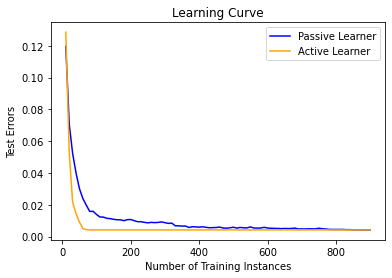

In [36]:
avg_test_scores_passive = []
avg_test_scores_active = []

for i in range(len(scores["passive"][0])):
    tot_score = 0
    for m in range(M):
        tot_score += scores["passive"][m][i]
    avg_test_scores_passive.append(tot_score/M)
    tot_score = 0
    for m in range(M):
        tot_score += scores["active"][m][i]
    avg_test_scores_active.append(tot_score/M)
    
train_instances = [x for x in range(10,901,10)]

plt.title(f'Learning Curve')
plt.plot(train_instances, avg_test_scores_passive, 'blue', label = 'Passive Learner')
plt.plot(train_instances, avg_test_scores_active, 'orange', label = 'Active Learner')
plt.legend(loc = 'upper right')
plt.ylabel('Test Errors')
plt.xlabel('Number of Training Instances')
plt.show()

## Conclusions
The active learner unsurprisingly learns faster